<a href="https://colab.research.google.com/github/lgalotto/analiseestatistica/blob/main/Bib_lgmaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biblioteca de Funções para a solução de Máquinas Assíncronas

In [ ]:
# Classe que armazena parametros de uma maquina assincrona.
class MaquinaAssincrona:
    def __init__(self, tensao, frequencia, polos=2, potencia=0, nfases=3, tipolig='Y', rs=0,xs=0,rr=0,xr=0,xm=0,dav=0):
        self.tensao = tensao
        self.frequencia = frequencia
        self.polos = polos
        self.potencia = potencia
        self.nfases = nfases
        self.tipolig = tipolig
        self.rs = rs
        self.xs = xs
        self.rr = rr
        self.xr = xr # reatancia de dispersao do rotor
        self.xm = xm # reatancia de magnetizacao no nucleo
        self.dav = dav # coeficiente de atrito dinamico

class RespostasMI:
    def __init__(self, Si, Ii, Ir, Pmec, Tmec, wm, Zeq):
      self.Si = Si
      self.Ii = Ii
      self.Ir = Ir
      self.Pmec = Pmec
      self.Tmec = Tmec
      self.wm = wm
      self.Zeq = Zeq

# os parametros de entrada Req,Xeq,Xm podem ser obtidos da funcao abaixo:
#
# ensaiosmiporfase
#
# f é a frequência da rede em Hz
# p o número de polos.
# Vi é a tensão de fase.
# S é o escorregamento para a condição de carga. S também pode ser vetor.

# Criado em 03/2016 - LGJ - melhorado 11/2018 - Melhorado em Python 04/2024

def calculomiporfase(MaquinaAssincrona,Vi,f,S):
    from numpy import real, abs, conjugate, pi

    if abs(S) > 0.00001:
      # impedancias
      Rotor = complex((MaquinaAssincrona.rr)/S,(MaquinaAssincrona.xr))
      Estator = complex(MaquinaAssincrona.rs,MaquinaAssincrona.xs)
      Zm = complex(0,MaquinaAssincrona.xm)
      Zeq = Estator + Zm/(1 + Zm/Rotor)
      # Correntes
      Ii = Vi/Zeq
      Ir = (Ii*Zm)/(Rotor + Zm)
    else:
      # impedancias
      # Rotor = infinito
      Estator = complex(MaquinaAssincrona.rs,MaquinaAssincrona.xs)
      Zm = complex(0,MaquinaAssincrona.xm)
      Zeq = Estator + Zm
      # Correntes
      Ii = Vi/Zeq
      Ir = 0

    # Potencias
    Si = Vi*conjugate(Ii) # De Entrada
    Pg = real(Si) - MaquinaAssincrona.rs*(abs(Ii) ** 2) # Pot. do entreferro
    Pmec = Pg - MaquinaAssincrona.rr*(abs(Ir)**2) # Convertida: (abs(Ir).^2*(Req/2)).*(1-S)./S;
    # Mecanicos
    ws = 2*pi*(f/(MaquinaAssincrona.polos/2))
    wm = ws*(1 - S)
    if wm > 1:
        Tmec = Pmec/wm
    else:
        Tmec = MaquinaAssincrona.rr * (abs(Ir) ** 2)/(S*ws)

    return (Si, Ii, Ir, Pmec, Tmec, wm)



# Criado LGJ - 04/2024
def calculomi(MaquinaAssincrona,Vi=0,f=0,S=0,wm=0):
    from numpy import pi, sqrt, real

    if Vi == 0:
      Vi = MaquinaAssincrona.tensao
    if f == 0:
      f = MaquinaAssincrona.frequencia
    if wm != 0:
      ws = 2*pi*(f/(MaquinaAssincrona.polos/2))
      S = (ws-wm)/ws

    if MaquinaAssincrona.tipolig == 'Y':
      Vfase = Vi/sqrt(3)
      Si, Ii, Ir, Pmec, Tmec, wm = calculomiporfase(MaquinaAssincrona,Vfase,f,S)
      Ilinha = Ii
    else:
      Vfase = Vi
      Si, Ii, Ir, Pmec, Tmec, wm = calculomiporfase(MaquinaAssincrona,Vfase,f,S)
      Ilinha = Ii*sqrt(3)

    Perdaseletricas = MaquinaAssincrona.nfases*(MaquinaAssincrona.rs*(abs(Ii)**2) + MaquinaAssincrona.rr*(abs(Ir)**2))
    Perdasav = MaquinaAssincrona.dav*(wm**2)
    #Pu = MaquinaAssincrona.nfases*real(Si) - Perdaseletricas - Perdasav
    Tu = MaquinaAssincrona.nfases*Tmec - MaquinaAssincrona.dav*wm

    return (3*Si, Ilinha, Tu, wm, Perdaseletricas, Perdasav)

# function [S0,Xm,Req,Xeq] = ensaiosmiporfase(Voc, Ioc, Poc, Vbl, Ibl, Pbl)
#
# Função criada para retornar os parâmetros de ensaios de motores de
# indução.
#

# Criado em MATLAB 03/2016 - LGJ - Melhorada - 04/2024
def ensaiosmiporfase(Voc, Ioc, Poc, Vbl, Ibl, Pbl, Rs = 0):
    from numpy import sqrt
    # Do ensaio com rotor bloqueado
    if Pbl > Vbl*Ibl: # warning('Potência ativa deve ser menor do que a Aparente. Corrigindo:');
      Pbl = Vbl*Ibl
    # Do ensaio a vazio
    if Poc > Voc*Ioc: #warning('Potência ativa deve ser menor do que a Aparente. Corrigindo:');
      Poc = Voc*Ioc

    Req = Pbl/(Ibl**2)
    if Rs == 0:
      Rr = Req/2
      Rs = Req/2
    else:
      Rr = Req - Rs

    Qbl = sqrt((Vbl*Ibl) ** 2 - (Pbl ** 2))
    metodo = 2
    if metodo == 1:
      Xeq = Req*Qbl/Pbl  # Req*tan(acos(Pbl/(Vbl*Ibl)))
      Rpeq = (Voc ** 2)/Poc
      #S0 = (Req/2)/((Req/2) + Rpeq)
      Xm = Voc/sqrt((Ioc ** 2) - (Voc/Rpeq) ** 2)
    else:
      Xeq = Qbl/(Ibl**2)  # Req*tan(acos(Pbl/(Vbl*Ibl)))
      Qoc = sqrt((Voc*Ioc) ** 2 - (Poc ** 2))
      Xm = Qoc/(Ioc ** 2)

    # Motor classe A - Norma IEEE 112
    Xs = Xeq/2
    Xr = Xeq/2

    return Xm,Rr,Rs,Xs,Xr

# Criado por LGJ - 04/2024
def ensaiosmi(Voc, Ioc, Poc, Vbl, Ibl, Pbl, Rs = 0, tipolig = 'Y', freq = 60, polos = 4, S0 = 0, nfases = 3):
    from numpy import sqrt, pi
    if tipolig == 'Y':
      Vconv = 1/sqrt(3)
      Iconv = 1
    else:
      Vconv = 1
      Iconv = sqrt(3)

    Xm,Rr,Rs,Xs,Xr = ensaiosmiporfase(Voc*Vconv, Ioc*Iconv, Poc/3, Vbl*Vconv, Ibl*Iconv, Pbl/3, Rs)

    Pav = Poc - 3*Rs*((Ioc*Iconv) ** 2) #Pav = 3 * ((Voc*Vconv) ** 2)/(Rr*(1 - S0)/S0)
    ws = 2*pi*freq/(polos/2)
    wm = (1 - S0)*ws
    Dav = Pav / (wm ** 2)

    maquina = MaquinaAssincrona(tensao=Voc, frequencia=freq, polos=polos, potencia = sqrt(3)*Voc*Ioc, rs=Rs, xs=Xs, rr=Rr, xr=Xr, xm=Xm, dav = Dav, nfases = nfases)

    return maquina

def plotcurvasmi(MaquinaAssincrona,Vi=0,freq=0,Sini=0.1,Sfim=1.0): # Vi=0,f=0,S=0,wm=0
    import matplotlib.pyplot as plt
    from numpy import linspace, zeros, real, pi, round
    S = linspace(Sini,Sfim,100)
    Pi = zeros((100,1))
    wm = zeros((100,1))
    Perdaseletricas = zeros((100,1))
    Perdasav = zeros((100,1))
    Pu = zeros((100,1))
    fp = zeros((100,1))
    nu = zeros((100,1))
    Tu = zeros((100,1))
    Tmec = zeros((100,1))
    Tmax = -1000
    wmax = 0
    ws = 2*pi*freq/(MaquinaAssincrona.polos/2)

    for k in range(100):
      Si, Ilinha, Tu[k], wm[k], Perdaseletricas[k], Perdasav[k] = calculomi(MaquinaAssincrona,Vi=Vi,f=freq,S=S[k])
      Pi[k] = real(Si)
      fp[k] = Pi[k]/abs(Si)

      Pu[k] = Tu[k]*wm[k]
      if Pi[k] > 0.1: # Eficiencia para gerador
        nu[k] = 1 - (Perdaseletricas[k] + Perdasav[k])/Pi[k]
      elif Pu[k] < -0.1: # Eficiencia para motor
        nu[k] = 1 - (Perdaseletricas[k] + Perdasav[k])/(-Pu[k])
      else:
        nu[k] = 0
      if abs(wm[k]) > 1:
        Tmec[k] = Tu[k] + (Perdasav[k])/wm[k]
      else:
        Tmec[k] = Tu[k]
      if Tu[k] > Tmax:
        Tmax = Tu[k]
        wmax = wm[k]


    fig,axs = plt.subplots(3,1,figsize=(12,8))
    axs[0].plot(wm,Pi,label='Entrada')
    axs[0].plot(wm,Perdasav,label='Perdas A.V.')
    axs[0].plot(wm,Perdaseletricas,label='Perdas Elétricas')
    axs[0].plot(wm,Pu,label='Potência Útil')
    axs[0].set_title('Operação do MIT')
    axs[0].set_ylabel('Potências (W)')
    axs[0].grid()
    axs[0].axvline(x=ws, color='red', linestyle='--',label='$\omega_s$')
    axs[0].legend()

    axs[1].plot(wm,nu,label='Eficiência')
    axs[1].plot(wm,fp,label='Fator de Potência')
    axs[1].grid()
    axs[1].legend()
    axs[1].axvline(x=ws, color='red', linestyle='--',label='$\omega_s$')

    axs[2].plot(wm,Tu,label='Torque útil')
    axs[2].plot(wm,Tmec,label='Torque induzido')
    axs[2].set_ylabel('Torque (Nm)')
    axs[2].set_xlabel('$\omega_m$ (rad/s)')
    axs[2].axvline(x=wmax, color='blue', linestyle='--',label='$T_{max}$ = ' + str(round(Tmax)) + ' Nm')
    axs[2].grid()
    axs[2].legend()
    axs[2].axvline(x=ws, color='red', linestyle='--',label='$\omega_s$')


def plotcurvasmitorque(MaquinaAssincrona,Vi=0,freq=0,Sini=0.1,Sfim=1.0,Tcarga=None,Dcarga=None): # Vi=0,f=0,S=0,wm=0
    import matplotlib.pyplot as plt
    from numpy import linspace, zeros, real, pi, round
    S = linspace(Sini,Sfim,100)
    wm = zeros((100,1))
    Tu = zeros((100,1))
    Ilinha = zeros((100,1),dtype=complex)
    Tmax = -1000
    wmax = 0
    weq = 0
    ws = 2*pi*freq/(MaquinaAssincrona.polos/2)
    Tcarga = zeros((100,1))

    for k in range(100):
      Si, Ilinha[k], Tu[k], wm[k], Perdaseletricas, Perdasav = calculomi(MaquinaAssincrona,Vi=Vi,f=freq,S=S[k])
      if Tu[k] > Tmax:
        Tmax = Tu[k]
        wmax = wm[k]
      if Dcarga is not None:
        Tcarga[k] = Dcarga * wm[k]
        if abs(Tcarga[k] - Tu[k]) < Tmax/10:
          weq = wm[k]

    fig,axs = plt.subplots(figsize=(12,4))
    axs.set_title('Curvas de Operação do MIT')
    axs.plot(wm,Tu,label='Torque útil', color="blue")
    axs.set_ylabel('Torque (Nm)', color="blue")
    axs.set_xlabel('$\omega_m$ (rad/s)')
    axs.axvline(x=wmax, color='blue', linestyle='--',label='$T_{max}$ = ' + str(round(Tmax)) + ' Nm')
    axs.grid()

    if Dcarga is not None:
      axs.plot(wm,Tcarga,label='Torque de Carga', color="green")
      axs.axvline(x=weq, color='green', linestyle='--',label='Equilíbrio')

    ax2 = axs.twinx()
    ax2.plot(wm,abs(Ilinha),label='Corrente de Linha', color="red")
    ax2.set_ylabel('Corrente de linha (A)', color="red")
    axs.legend()
    axs.axvline(x=ws, color='red', linestyle='--',label='$\omega_s$')


## Exemplo de MIT 380V - com parametros simples

In [ ]:
#Exemplo de uso:

maquina = MaquinaAssincrona(tensao=380, frequencia=60, polos=4, rs=1, xs=1, rr=1, xr=1, xm=100)

S = 0.01

import numpy as np
Si, Ii, Ir, Pmec, Tmec, wm = calculomiporfase(maquina,220,60,S)
print('--- Cálculo por fase ---')
print('Potencia de entrada: ' + str(Si))
print('Corrente de entrada: ' + str(np.abs(Ii)) + ' <' + str(np.angle(Ii,deg=True)))
print('Corrente do rotor: ' + str(np.abs(Ir)) + ' <' + str(np.angle(Ir,deg=True)))
print('Potência mecânica: ' + str(Pmec) + ' W')
print('Torque mecânico: ' + str(Tmec) + ' Nm')
print('Rotação: ' + str(wm) + ' rad/s')

maquina.dav = 30 / (wm ** 2) # calculo do coeficiente de atrito para as perdas nesta rotacao

print(' ')
print('--- Cálculo trifásico (total) ---')

Sitotal, Ilinha, Tu, wm, Perdaseletricas, Perdasav = calculomi(maquina,S=S)
Pu = Tu*wm
print('Potencia Total de entrada: ' + str(Sitotal))
print('fator de potência: ' + str(np.real(Sitotal)/np.abs(Sitotal)))
print('Perdas elétricas totais:' + str(Perdaseletricas) + ' W')
print('Perdas de atrito e ventilação:' + str(Perdasav) + ' W')
print('Potencia Útil de saída: ' + str(Pu) + ' W')
print('Torque Útil: ' + str(Tu) + ' Nm')
print('Eficiência: ' + str(100*Pu/np.real(Sitotal)) + '%')
print('Rotação: ' + str(wm) + ' rad/s')

#Rotor = complex((maquina.rr)/1,(maquina.xr))
#Estator = complex(maquina.rs,maquina.xs)
#Zm = complex(0,maquina.xm)
#Zeq = Estator + Zm/(1 + Zm/Rotor)
#Ii = 220/Zeq
#Irpartida = (Ii*Zm)/(Rotor + Zm)



--- Cálculo por fase ---
Potencia de entrada: (474.46375298184586+479.16094883356214j)
Corrente de entrada: 3.0651030606373517 <-45.28221513227412
Corrente do rotor: 2.156545608628571 <-0.5672664098579435
Potência mecânica: 460.41820724742223 W
Torque mecânico: 2.467267123667878 Nm
Rotação: 186.6106036232337 rad/s
 
--- Cálculo trifásico (total) ---
Potencia Total de entrada: (1415.548882863193+1429.5628308174867j)
fator de potência: 0.7036153042750555
Perdas elétricas totais:41.90447942253663 W
Perdas de atrito e ventilação:30.0 W
Potencia Útil de saída: 1343.6444034406568 W
Torque Útil: 7.200257527452573 Nm
Eficiência: 94.92038174781383%
Rotação: 186.6106036232337 rad/s


In [ ]:
print('--- Condição de Partida da Máquina (S=1) ---')
Si, Ii, Irpartida, Pmec, Tmec, wm = calculomiporfase(maquina,220,60,1)

print('Corrente de partida:' + str(abs(Irpartida)) + ' A')
Tpartida = maquina.nfases * Tmec
# OU
# ws = 2*np.pi*60/(maquina.polos/2)
# Tpartida = maquina.nfase * maquina.rr * (abs(Irpartida) ** 2) / ws
print('Torque de partida: ' + str(Tpartida) + ' Nm')

--- Condição de Partida da Máquina (S=1) ---
Corrente de partida:77.39381425556886 A
Torque de partida: 95.33066736359257 Nm


--- Condição de Torque Máximo (S=Smax) ---
Corrente no Smax:57.73906826501169 A
Torque maximo: 117.70835495648211 Nm
Rotação: 103.52792870154134 rad/s
 


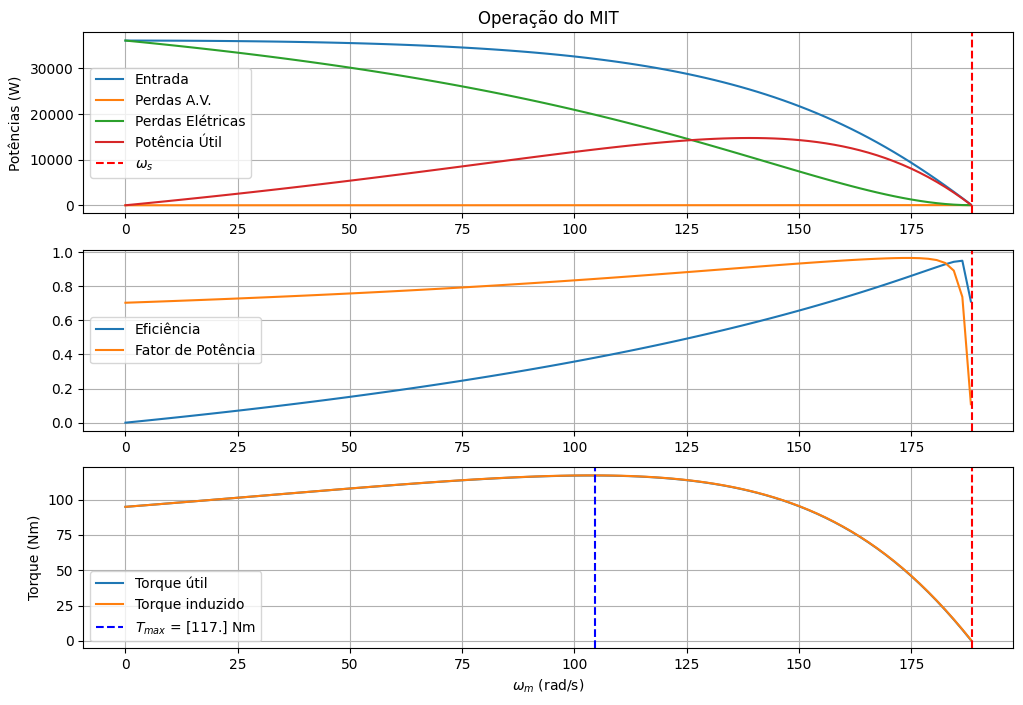

In [ ]:
print('--- Condição de Torque Máximo (S=Smax) ---')

rth = (maquina.rs*maquina.xm**2)/((maquina.xs + maquina.xm)**2)
xth = (maquina.xs*maquina.xm)/(maquina.xs + maquina.xm)
smax = maquina.rr/np.sqrt(rth**2 + (xth + maquina.xr)**2)

Si, Ii, Irmax, Pmec, Tmec, wm = calculomiporfase(maquina,220,60,smax)

Tmaximo = maquina.nfases * Tmec
# OU
# Tmaximo = maquina.nfase * maquina.rr * (abs(Irmax) ** 2) / (ws*smax)
print('Corrente no Smax:' + str(abs(Irmax)) + ' A')
print('Torque maximo: ' + str(Tmaximo) + ' Nm')
print('Rotação: ' + str(wm) + ' rad/s')
print(' ')

plotcurvasmi(maquina,380,60,0.001,1)

In [ ]:
maquina = MaquinaAssincrona(tensao=380, frequencia=60, polos=4, rs=1, xs=1, rr=1, xr=1, xm=100)

S = -0.01

import numpy as np
Si, Ii, Ir, Pmec, Tmec, wm = calculomiporfase(maquina,220,60,S)
print('--- Cálculo por fase ---')
print('Potencia de entrada: ' + str(Si))
print('Corrente de entrada: ' + str(np.abs(Ii)) + ' <' + str(np.angle(Ii,deg=True)))
print('Corrente do rotor: ' + str(np.abs(Ir)) + ' <' + str(np.angle(Ir,deg=True)))
print('Potência mecânica: ' + str(Pmec) + ' W')
print('Torque mecânico: ' + str(Tmec) + ' Nm')
print('Rotação: ' + str(wm) + ' rad/s')

maquina.dav = 30 / (wm ** 2) # calculo do coeficiente de atrito para as perdas nesta rotacao

print(' ')
print('--- Cálculo trifásico (total) ---')

Sitotal, Ilinha, Tu, wm, Perdaseletricas, Perdasav = calculomi(maquina,S=S)
Pu = Tu*wm
print('Potencia Total Elétrica: ' + str(Sitotal))
print('fator de potência: ' + str(np.real(Sitotal)/np.abs(Sitotal)))
print('Perdas elétricas totais:' + str(Perdaseletricas) + ' W')
print('Perdas de atrito e ventilação:' + str(Perdasav) + ' W')
print('Potencia Útil (entrada): ' + str(Pu) + ' W')
print('Torque Útil: ' + str(Tu) + ' Nm')
print('Eficiência: ' + str(100*np.real(Sitotal)/Pu) + '%')
print('Rotação: ' + str(wm) + ' rad/s')

--- Cálculo por fase ---
Potencia de entrada: (-473.8881414943422+498.3138644454244j)
Corrente de entrada: 3.1257616531236536 <-133.5607965457337
Corrente do rotor: 2.199223788991199 <-178.2757452681499
Potência mecânica: -488.49511268054533 W
Torque mecânico: -2.565888180176277 Nm
Rotação: 190.38051480754146 rad/s
 
--- Cálculo trifásico (total) ---
Potencia Total Elétrica: (-1413.8315626401447+1486.7050005355222j)
fator de potência: -0.6891238826990792
Perdas elétricas totais:43.57947601834154 W
Perdas de atrito e ventilação:30.0 W
Potencia Útil (entrada): -1487.4110386584862 W
Torque Útil: -7.812832317226017 Nm
Eficiência: 95.05318475485407%
Rotação: 190.38051480754146 rad/s
